datasets, fastprogress, torcheval

In [1]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
# from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
# from miniai.xtras import *

/scratch/user/shipalnomoo/.conda/envs/jl/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
mpl.rcParams['image.cmap'] = 'gray'

In [26]:
import torchvision
from torch import tensor, nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

def get_dls(bs=1024, seed=42, root='$SCRATCH/data'):
    """Grab MNIST fasion data using pytorch dataset."""
    set_seed(seed)
    root = os.path.expandvars(root)
    xmean, xstd = (tensor(0.29), tensor(0.35))
    def batch_tfm(img): return (ToTensor()(img) - xmean) / xstd
    trn_ds = datasets.FashionMNIST(
        root=root, train=True, download=True, transform=batch_tfm
    )
    val_ds = datasets.FashionMNIST(
        root=root, train=False, download=True, transform=batch_tfm
    )
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=True)
    return DataLoaders(trn_dl, val_dl)

In [27]:
dls = get_dls()
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 7, 4, 7, 3, 8, 9, 5, 3, 1]))

In [11]:
metrics = MetricsCB(accuracy=MulticlassAccuracy(), device='cpu')
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=False), astats]
iw = init_weights

In [12]:
model = get_model(norm=nn.BatchNorm2d).apply(init_weights)

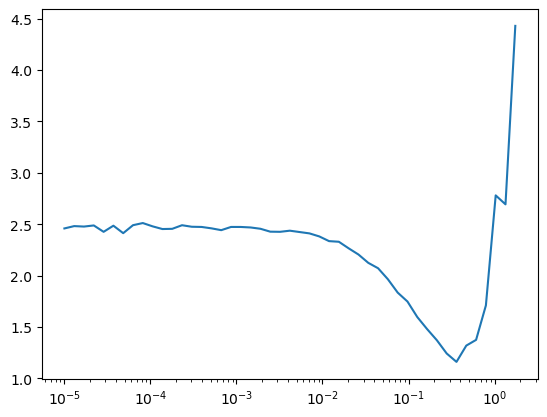

In [6]:
learn = TrainLearner(model, dls, F.cross_entropy, lr=.01, cbs=cbs)
learn.lr_find()

In [13]:
learn.fit(2, lr=3e-2)

accuracy,loss,epoch,train
0.752,0.738,0,train
0.752,0.717,0,eval
0.766,0.670,1,train
0.762,0.665,1,eval


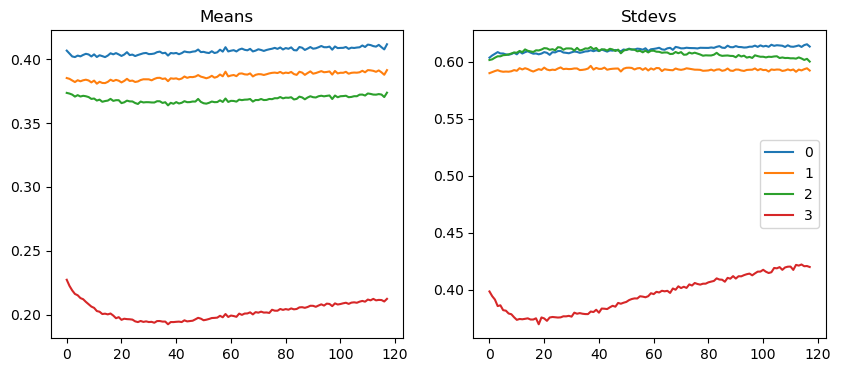

In [8]:
astats.plot_stats()